## Software cost estimation II

**1. 	¿Qué tipo de correlación existe entre el lenguaje de programación usado y el esfuerzo total del proyecto?**

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import seaborn as sns
from matplotlib import cm
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
df_fp = pd.read_excel('../input/fp.xlsx', delim_whitespace = True,
names=['id', 'Project', 'TeamExp', 'ManagerExp', 'YearEnd', 'Length', 'Effort', 'Transactions','Entities', 'PointsNonAdjust', 'Adjustment', 'PointsAjust','Language']
)
df_fp.dataframeName = 'fp.xlsx'
labels = list('AB')
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [ ]:
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

costLeng = [df_fp.Effort,df_fp.Language]
np.cov(costLeng)

Vemos que  correlación entre esfuerzo y lenguaje es inversamente proporcional.
Veamos con más detalle el coeficiente de  correlación entre las variables del data set: 

In [ ]:
plt.figure(figsize=(10, 12))
sns.heatmap(df_fp.corr(),square=True, annot=True, linewidths=.5)

El color blanco indica que las variables están  fuertemente correlacionadas y cuanto más hacia el rojo oscuro mayor es la relación;  cuanto más hacia el azul mayor correlación inversa.

Veramos un gráfico de dispersión  y correlación de la varables: 

In [ ]:
    plotScatterMatrix(df_fp, 20, 10)

A esta altura ya podemos reponder algunas de las preguntas que nos planteamos al inicio, por ejemplo: 
¿Qué tipo de correlación existe entre el lenguaje de programación usado y el esfuerzo total del proyecto?
¿La inexperiencia  del equipo de desarrollo incrementa el costo del proyecto?
¿Qué tipo de correlación existe entre los puntos de función sin ajustar y la experiencia del director del proyecto?

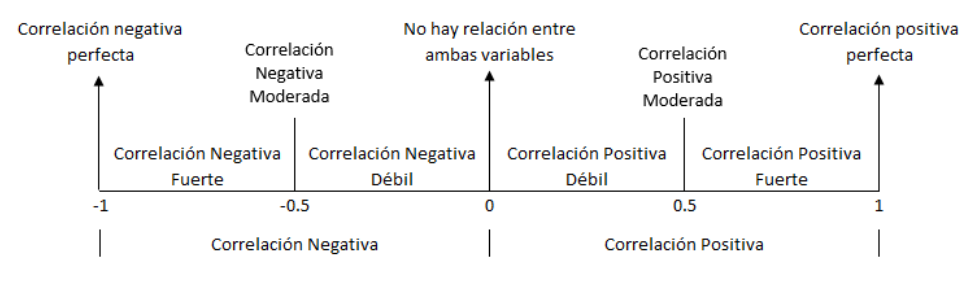

Sorprende un poco por ejmeplo que la correlación entre el esfuerzo total y la experiencia del equipo de desarrollo sea tan débil, lo mismo se concluye al comparara con la experiencia del líder del proyecto. 

También se parecería sugerirse que a mayor esfuerzo (costo) menor es el número de lenguajes utilizados.

Para predecir  el esfuerzo de los proyectos de  software vamos a utilizar un modelo de regresión lineal de las variables que tengan un mayor correlación con el esfuerzo total.

Vaamos a hacer un modelo de regresión simple entre el esfuerzo total y los puntos de función ajustados por cada proyecto: 

In [ ]:
filtered_data = df_fp[(df_fp['PointsAjust'] <= max(df_fp.PointsAjust)) & (df_fp['Effort'] <= max(df_fp.Effort))]
colores=['orange','blue']
tamanios=[30,60]
f1 = filtered_data['PointsAjust'].values
f2 = filtered_data['Effort'].values
# Vamos a pintar en colores los puntos por debajo y por encima de la media de los puntos de función
asignar=[]
for index, row in filtered_data.iterrows():
    if(row['PointsAjust']> f1.mean()):
        asignar.append(colores[0])
    else:
        asignar.append(colores[1])
    
plt.scatter(f1, f2, c=asignar, s=tamanios[0])
plt.show()

## Modelo de Regresión

Vamos a crear nuestros datos de entrada por el momento sólo  con los PointsAjustt y como etiquetas los esfuerzos totales. Creamos el objeto LinearRegression y lo hacemos “encajar” (entrenar) con el método fit(). Finalmente imprimimos los coeficientes y puntajes obtenidos.

In [ ]:
# Asignamos nuestra variable de entrada X para entrenamiento y las etiquetas Y.
dataX =filtered_data[["PointsAjust"]]
X_train = np.array(dataX)
y_train = filtered_data['Effort'].values
 
# Creamos el objeto de Regresión Linear
regr = linear_model.LinearRegression()
 
# Entrenamos nuestro modelo
regr.fit(X_train, y_train)
 
# Hacemos las predicciones,  una línea (en este caso, al ser 2D)
y_pred = regr.predict(X_train)
 
# Veamos los coeficienetes obtenidos, En nuestro caso, serán la Tangente
print('Coeficientes: \n', regr.coef_)
# Este es el valor donde corta el eje Y (en X=0)
print('Termino independiente: \n', regr.intercept_)
# Error Cuadrado Medio
print("Error cuadratico medio: %.2f" % mean_squared_error(y_train, y_pred))
# Puntaje de Varianza. El mejor puntaje es un 1.0
print('Varianza: %.2f' % r2_score(y_train, y_pred))

Dada la ecuación de la recta y = mX + b , la pendiente “m” es el coeficiente 17.56151894 y el término independiente “b” es -33.08970136642529. EL error cuadrático medio es gigantesco, así que el modelo es muy malo.

**Graficamos la recta:**


In [ ]:
dataX =filtered_data[["PointsAjust"]]
X_train = np.array(dataX)
y_train = filtered_data['Effort'].values
b=-33.08970136642529
m= 17.56151894 
plt.scatter(dataX, y_train , c='blue', edgecolors=(0, 0, 0), alpha=0.5)
plt.plot(X_train, [b + m * x for x in X_train])
plt.show()


** Predicción con regresión lineal simple: **

Vamos a intentar probar nuestro modelo , suponiendo que quisiéramos predecir cuánto es el costo de un proyecto de software que obtendría, por ejemplo, 150 puntos de función ajustados:


In [ ]:
y_Effort = regr.predict([[150]])
print(int(y_Effort)) 

2601 Horas hombre.   Relamente ya vimos que el modelo no es tan bueno en este caso.

## Regresión con múltiples variables
Vamos a usar más variable de nuestro data set  para predecir el costo de un proyecto similar de software. La ecuación de la recta que ahora podremos plantear será algo como:

*Y = b + m1 X1 + m2 X2 + … + m(n) X(n)*

Utilizaremos ahora dos  “variables predictivas” para poder graficar en 3D.

Nuestra primer variable va a ser la duración del proyecto y la segunda variable será la suma de dos columnas de entrada: los años de experiencia del equipo de desarrollo y la experiencia del líder del proyecto, medidas ewn años:

In [ ]:
#Vamos a intentar mejorar el Modelo, con una dimensión más: 
# Para poder graficar en 3D, haremos una variable nueva que será la suma mencionada arriba.
suma = (filtered_data["TeamExp"] + filtered_data['ManagerExp'])
dataX2 =  pd.DataFrame()
dataX2["Length"] = filtered_data["Length"]
dataX2["suma"] = suma
XY_train = np.array(dataX2)
z_train = filtered_data['Effort'].values

#Creamos un nuevo objeto de Regresión lineal  que  tendrá  dos dimensiones
#para  entrenar: las que contiene XY_train

regr2 = linear_model.LinearRegression()
 
# Entrenamos el modelo, esta vez, con 2 dimensiones
# obtendremos 2 coeficientes, para graficar un plano
regr2.fit(XY_train, z_train)
 
# Hacemos la predicción con la que tendremos puntos sobre el plano hallado
z_pred = regr2.predict(XY_train)
 
# Los coeficientes
print('Coeficientes: \n', regr2.coef_)
# Error cuadrático medio
print("Error cuadratico medio: %.2f" % mean_squared_error(z_train, z_pred))
# Evaluamos la varianza (siendo 1.0 el mejor posible)
print('Varaianza: %.2f' % r2_score(z_train, z_pred))

Seguimos teniendo un error cuadrático medio alto pero mejor que el ejercicio anterior, la varianza mejoró respecto al modelo de una variable pero sigue si ser un resultado preciso.


In [ ]:
fig = plt.figure()
ax = Axes3D(fig)
 # Creamos una malla, sobre la cual graficaremos el plano
xx, yy = np.meshgrid(np.linspace(0, 3500, num=10), np.linspace(0, 60, num=10))
 
# calculamos los valores del plano para los puntos x e y
nuevoX = (regr2.coef_[0] * xx)
nuevoY = (regr2.coef_[1] * yy) 
 
# calculamos los correspondientes valores para z. Debemos sumar el punto de
#intercepción
z = (nuevoX + nuevoY + regr2.intercept_)
 
# Graficamos el plano
ax.plot_surface(xx, yy, z, alpha=0.2, cmap='hot')
 
# Graficamos en azul los puntos en 3D
ax.scatter(XY_train[:, 0], XY_train[:, 1], z_train, c='blue',s=30)
 
# Graficamos en rojo, los puntos que 
ax.scatter(XY_train[:, 0], XY_train[:, 1], z_pred, c='red',s=40)
 
# con azim podremos visualizar el grafico entre 0 y 360 grados.
ax.view_init(elev=30., azim= 30)

ax.set_xlabel('Longitud de proyecto')
ax.set_ylabel('Experiencia del equipo y líder del proyecto')
ax.set_zlabel('Esfuerzo total')
ax.set_title('Regresión Lineal con Múltiples Variables')

In [ ]:
#Vamos a intentar probar nuestro modelo , suponiendo que quisiéramos 
#predecir cuánto es el costo de un proyecto de software que obtendría,
#por ejemplo, 6  meses de duración, 2 años de experiencia del equipo y 10 
# anños de experiencia del lider: 

print('Prediccion: \n')
z_Effort= regr2.predict([[6, 2+10]])
print(int(z_Effort))


## Conclusión: 

En el ejercicio planteado tuvimos  un error cuadrático elevado, es decir, una  confianza  baja en las predicciones. En el primer modelo, con 150 puntos de función ajustados el modelo predice que podemos tener un esfuerzo total de 2601 horas/hombre pero el error cuartico medio es 8773579.47. En el segundo modelo, con más variables,  para un proyecto de  6  meses de duración, 2 años de experiencia del equipo y 10 
años de experiencia del líder obtuvimos un estimado de 2960 horas/hombre de trabajo y un error cuadrático medio de 10008844.87.

Para mejorar nuestro modelo, deberíamos utilizar más dimensiones y encontrar datos de entrada mejores.  El segundo modelo es consistente con nuestra matriz de coeficientes de correlación.



